## BIOENG-310: Neuroscience Foundations for Engineers

Notebook created by Yingtian Tang, edited by Alejandro Rodriguez Guajardo.

# Week 6: Gabor filtering and alignment to V1 neural activities

This week, we will learn how to construct **Gabor filters**, a family of image filters that were implicated to be similar to how V1 simple cells process the visual stimuli. They are essentially detectors for *edges* of different sizes and oridentations. Then, we will extract features from experimental stimuli using the Gabor filters, and compare to V1 activities on the same set of stimuli.

The notebook consists of the following sessions:
- **Gabor filtering**: construct Gabor filters (lots of work)
- **Alignment between Gabor filtering and monkey V1 activity**: using RDMs to compare Gabor features and V1 activities

Please complete the code in the sections marked '''%%...%%''' based on the given instructions and context. Then, run all the blocks to see the results.
Additional hints:
- You can open some temporary Python blocks as your scratchpad.
- Be careful of the ordering of running Python blocks, since the variables are shared.
- References are important: look at the input/output specifications of the functions.

Enjoy the journey! 🚀

**Before you begin**, execute the following block to install the required packages. (The following code might require you to *restart runtime*, which is fine)

In [2]:
!pip install jupyter brainscore-vision matplotlib

In [3]:
import numpy as np
import cv2
from matplotlib import image, pyplot

### Gabor filtering

A foundational approach ([Jones & Palmer](http://www.neuro-it.net/pdf_dateien/summer_2004/Jones%201987.pdf)) to modeling the receptive fields of V1 simple cells is through Gabor filters,
which detect wavelets of varying sizes, orientations, and spatial frequencies.

Let's construct the simplified version of these filters ourselves.

The family of filters can be represented mathmatically as:
$$g(x,y) = s(x,y)~w(x,y)$$
where $s(x,y)$ is a sinusoid known as the **carrier** and $w(x,y)$ is a 2D Gaussian-shaped function known as the **envelope**.

It means: at loction $x,y$, the connection strength of the Gabor filter is given by $g(x,y)$.

A helper function for constructing a mesh grid will be useful for visualizing these functions:

In [4]:
# generate a square mesh grid of certain size
def meshgrid(size):
    return np.mgrid[:size, :size] - (size // 2)

# visualize the meshgrid of size 11 x 11
xs, ys = meshgrid(11)
print(f"x values are:\n{xs}", end='\n\n')
print(f"y values are:\n{ys}")

x values are:
[[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
 [-4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3  3]
 [ 4  4  4  4  4  4  4  4  4  4  4]
 [ 5  5  5  5  5  5  5  5  5  5  5]]

y values are:
[[-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]]


What does the xs and ys mean? -> they are the x and y coordinates at each location of the square mesh grid.

We proceed to define the sinusoid $s(x,y)$:
$$s(x,y) = cos\left( \frac{2\pi \left(cos\theta~x+sin\theta~y \right)}{\lambda} \right)$$

In [5]:
# the 'lambda' is a reserved expression in Python, so we use `lambda_` instead
def sinusoid(x, y, theta, lambda_):
    return np.cos(2 * np.pi * (np.cos(theta) * x + np.sin(theta) * y) / lambda_)

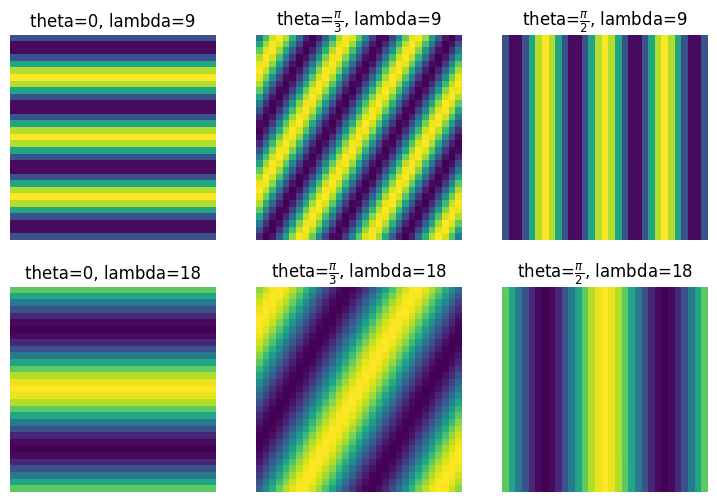

In [6]:
# visualize the sinusoid function
kernel_size = 31
xs, ys = meshgrid(kernel_size)
thetas_str = ["0", r"$\frac{\pi}{3}$", r"$\frac{\pi}{2}$"]
thetas = [0, np.pi / 3, np.pi / 2]
lambdas = [9, 18]

nrows = len(lambdas)
ncols = len(thetas)
fig, axes = pyplot.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))

for i, lambda_ in enumerate(lambdas):
    for j, theta in enumerate(thetas):
        axes[i, j].imshow(sinusoid(xs, ys, theta, lambda_), vmin=-1, vmax=1)
        axes[i, j].set_title(f"theta={thetas_str[j]}, lambda={lambdas[i]}")
        axes[i, j].axis("off")


What does $\theta$ mean? -> the rotation of the sinusoid.

What does $\lambda$ mean? -> the wavelength of the sinusoid.

Think again how $\theta$ and $\lambda$ mathematically transform the shape of the sinusoid.

If used as a detector, what feature can these sinusoids encode? -> edges of different widths and orientations.

Next, we turn to $w(x,y)$, which is defined as:
$$ w(x,y) = exp \left( - \frac{{x'}^2 + \gamma^2 {y'}^2}{2 \sigma^2} \right) $$
where
$$x' = cos\theta~x + sin\theta~y$$
$$y' = -sin\theta~x + cos\theta~y$$


In [7]:
def gaussian(x, y, theta, gamma, sigma):
    x_ = np.cos(theta) * x + np.sin(theta) * y
    y_ = -np.sin(theta) * x + np.cos(theta) * y
    return np.exp(-(x_**2 + gamma**2 * y_**2) / (2 * sigma**2))

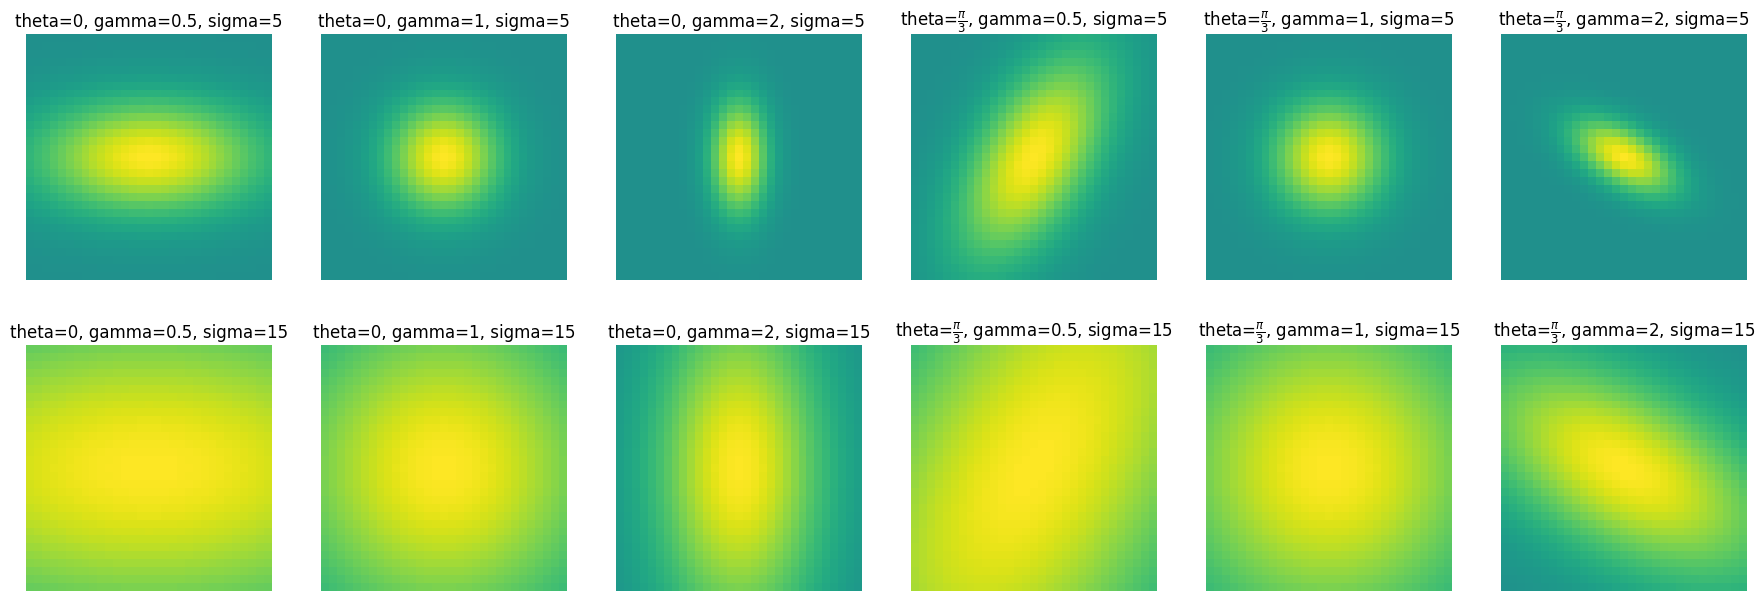

In [8]:
# visualize the envelope function
kernel_size = 31
xs, ys = meshgrid(kernel_size)
thetas = [0, np.pi/3]
thetas_str = ["0", r"$\frac{\pi}{3}$"]
gammas = [.5, 1, 2]
sigmas = [5, 15]

nrows = len(sigmas)
ncols = len(thetas) * len(gammas)
fig, axes = pyplot.subplots(nrows, ncols, figsize=(3.7 * ncols, 3.7 * nrows))

for i, sigma in enumerate(sigmas):
    for j, theta in enumerate(thetas):
        for k, gamma in enumerate(gammas):
            c = k + j * len(gammas)
            axes[i, c].imshow(gaussian(xs, ys, theta, gamma, sigma), vmin=-1, vmax=1)
            axes[i, c].set_title(f"theta={thetas_str[j]}, gamma={gamma}, sigma={sigma}")
            axes[i, c].axis("off")

# click the picture below to zoom in a bit

What does $x'$ and $y'$ mean?

-> $x'$ is the projection of the vector <$x,y$> onto the unit vector <$cos\theta, sin\theta$>, and $y'$ is the projection of the vector <$x,y$> onto the unit vector <$sin\theta, -cos\theta$>. The vectors <$cos\theta, sin\theta$> and <$sin\theta, -cos\theta$> form an orthogonal basis, with their orientations controlled by $\theta$.

What does $\gamma$ mean? -> it controls the ratio of the scales of $x'$ and $y'$ (aspect ratio). Originally, one can control the individual scales using terms like $\frac{{x'}^2}{\sigma_{x'}^2}+\frac{{y'}^2}{\sigma_{y'}^2}$.

What does $\sigma$ mean? -> it controls the size of the Gaussian kernal.

If we multiple the detector $s(x,y)$ by this Gaussian $w(x,y)$, what properties of the detector will be changed? (notice that they share the same $\theta$) -> the Gaussian will control the overall size of the receptive field.

Now, we put the $s(x,y)$ and $w(x,y)$ together and visualize the Gabor filter $g(x,t)$.

In [9]:
def gabor(x, y, theta, lambda_, gamma, sigma):
    return sinusoid(x, y, theta, lambda_) * gaussian(x, y, theta, gamma, sigma)

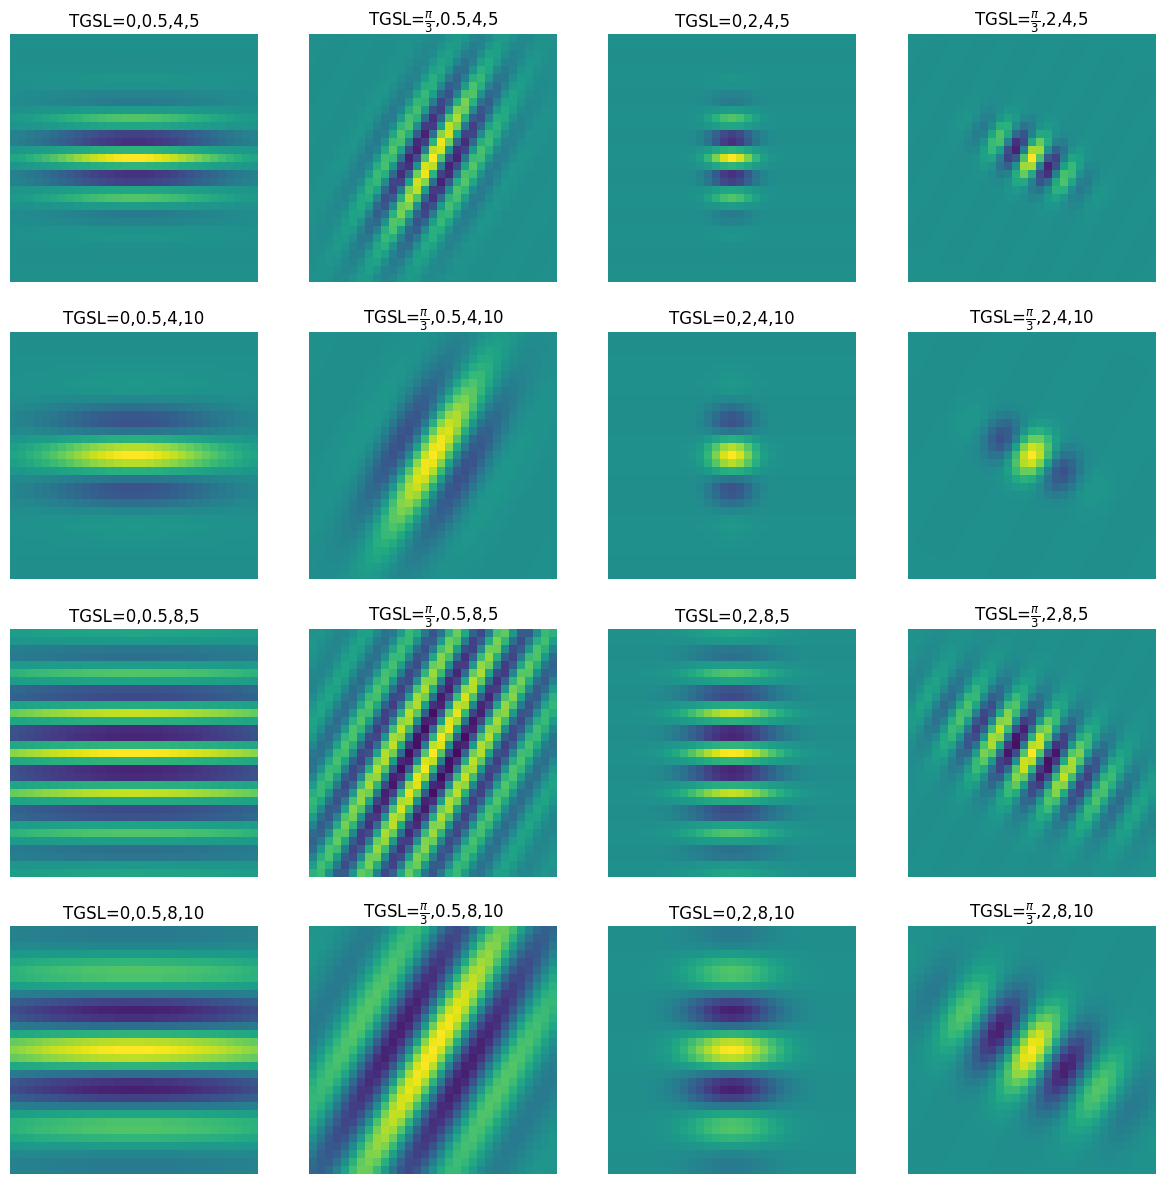

In [10]:
# visualize the gabor filter
kernel_size = 31
xs, ys = meshgrid(kernel_size)
thetas = [0, np.pi/3]
thetas_str = ["0", r"$\frac{\pi}{3}$"]
gammas = [.5, 2]
sigmas = [4, 8]
lambdas = [5, 10]

nrows = len(sigmas) * len(lambdas)
ncols = len(thetas) * len(gammas)
fig, axes = pyplot.subplots(nrows, ncols, figsize=(3.7 * ncols, 3.7 * nrows))

params_of_interests = []
for i, sigma in enumerate(sigmas):
    for j, lambda_ in enumerate(lambdas):
        for k, theta in enumerate(thetas):
            for l, gamma in enumerate(gammas):
                c = k + l * len(gammas)
                r = j + i * len(lambdas)
                axes[r, c].imshow(gabor(xs, ys, theta, lambda_, gamma, sigma), vmin=-1, vmax=1)
                axes[r, c].set_title(f"TGSL={thetas_str[k]},{gamma},{sigma},{lambda_}")
                axes[r, c].axis("off")

                if r==c: params_of_interests.append((theta, lambda_, gamma, sigma))

Recall: we have assumed that these Gabor filters correspond to the receptive fields of the V1 simple cells.

Let's consider one kind of V1 simple cell, say cells with tuning properties TGSL=$0,10,0.5,3$. It is reasonable to assume that the detection of this kind of feature should happen uniformly at every location of the retina.

Visually, the neurons will tile up the space spanned by the retina:

<img src="https://github.com/epflneuroailab/bioeng-310/blob/main/week6/neurons.png?raw=true" alt="drawing" width="400"/>

Here, the tiling is only illustrated in the horizontal direction and with exaggerated spacing. In the real case, there are also neurons in the vertical direction with little spacing between the receptive fields of different neurons, collectively forming a dense mesh grid of cells. This arrangement ensures that visual information is processed with high spatial resolution. The 2D outputs from this mesh grid can be computed using convolution, a mathematical operation that models how receptive fields in the visual system respond to stimuli.

In general, convolution plays a fundamental role in visual processing, both in biological and artificial systems. In the brain, neurons in the primary visual cortex (V1) act as spatial filters, detecting edges and textures by integrating signals from neighboring photoreceptors in the retina. This process is analogous to how convolutional filters in deep learning extract features from images. Specifically, neurons in V1 have Gabor-like receptive fields, meaning they respond preferentially to specific orientations and spatial frequencies. This is why convolutional neural networks (CNNs) often use Gabor filters in early layers to mimic biological vision.

Experimental studies, such as those by [Hubel and Wiesel (1962)](https://pmc.ncbi.nlm.nih.gov/articles/PMC1359523/), demonstrated that the visual cortex contains neurons with orientation-selective receptive fields, organized in a grid-like pattern. This arrangement enables the brain to efficiently decompose visual input into fundamental features, a process critical for object recognition and motion detection.

Let's now assume that the retina (retinal ganglion cells, or RGCs) simply encodes the grayscale values of an image, which is an oversimplification. These cells have center-surround antagonism, where some cells (ON-center) activate when light increases in their center but decrease when it spreads to their surrounding area, while others (OFF-center) do the opposite. However, there are also other RGCs that process color and motion before sending signals to the lateral geniculate nucleus (LGN), and then to V1.

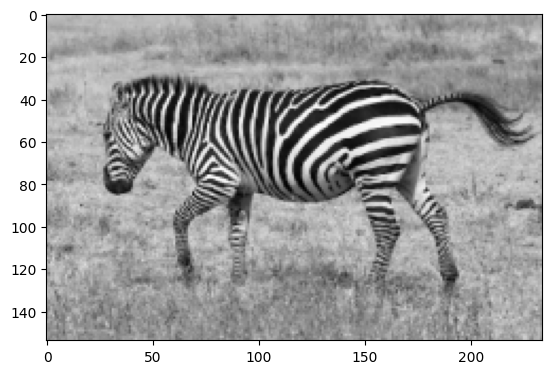

In [11]:
import urllib

# load the example image
url = "https://github.com/epflneuroailab/bioeng-310/blob/main/week6/zebra.png?raw=true"
save_path = 'zebra.png'
urllib.request.urlretrieve(url, save_path)
img = image.imread(save_path)[...,:3] @ [0.2989, 0.5870, 0.1140]  # conver to grayscale
pyplot.imshow(img, cmap='gray')

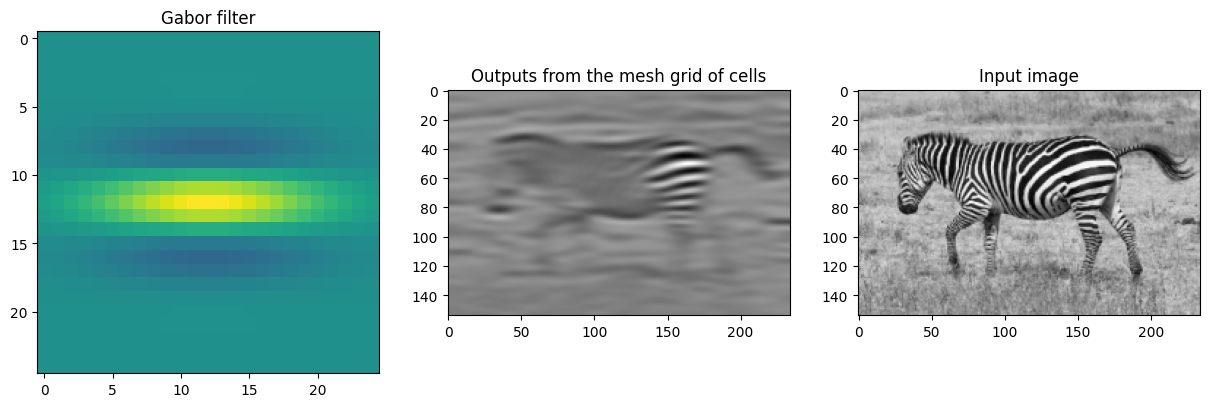

In [12]:
# we use a convolution implementation in opencv
def convolve2d(img, filter):
    return cv2.filter2D(img, -1, filter)

# we settle the overall size of the receptive field to be 50
kernel_size = 25
xs, ys = meshgrid(kernel_size)

# define the Gabor filter of interests
# a mesh grid of V1 simple cells share this tuning property
filter = gabor(xs, ys, theta=0, lambda_=10, gamma=0.5, sigma=3)

# using convolution to simulate the outputs of the mesh grid
cells_outputs = convolve2d(img, filter)

fig, axes = pyplot.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(filter, vmin=-1, vmax=1)
axes[1].imshow(cells_outputs, cmap='gray')
axes[2].imshow(img, cmap='gray')
axes[0].set_title("Gabor filter")
axes[1].set_title("Outputs from the mesh grid of cells")
axes[2].set_title("Input image")
pyplot.show()

What did you see? What does this kind of cells detect? -> the cells detect the horizontal edges. The strong feature encoding happens at around the hip of the zebra.

What do the strong green/black colors mean in the outputs? -> strong postive/negative outputs of the cells.

Let's check the outputs from more groups of cells.

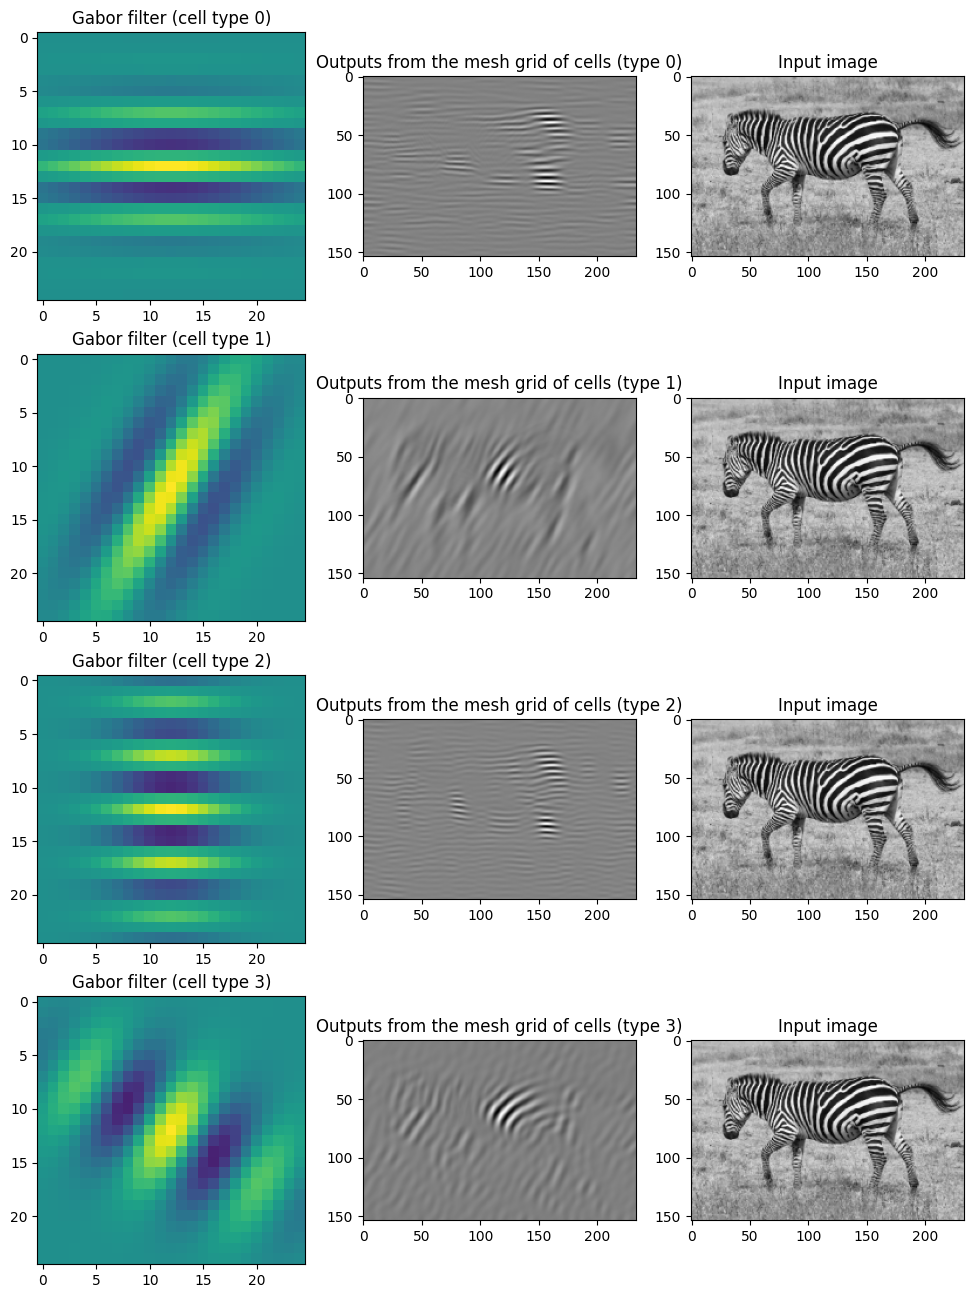

In [13]:
fig, axes = pyplot.subplots(len(params_of_interests), 3, figsize=(12, 4 * len(params_of_interests)))

for i, params in enumerate(params_of_interests):
    filter = gabor(xs, ys, *params)
    cells_outputs = convolve2d(img, filter)

    axes[i, 0].imshow(filter, vmin=-1, vmax=1)
    axes[i, 1].imshow(cells_outputs, cmap='gray')
    axes[i, 2].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"Gabor filter (cell type {i})")
    axes[i, 1].set_title(f"Outputs from the mesh grid of cells (type {i})")
    axes[i, 2].set_title("Input image")
pyplot.show()

### Alignment between Gabor filtering and monkey V1 activity

Now, we will evaluate the brain alignment of Gabor filters. Specifically, we aim to assess how similar the computations of Gabor filtering are to those in the primary visual cortex (V1):
1. We present the same set of stimuli to both systems and collect their **responses (i.e., features)**.
2. We compute a characteristic matrix of these responses, known as the **Representational Dissimilarity Matrix (RDM)**.
3. We then **compare the RDMs** from the Gabor filters and V1 to assess how similar the two systems are.

To begin with, we need to extract the Gabor filter features from the stimuli and also load and preprocess the V1 data.

In [14]:
import brainscore_vision
from brainscore_vision.benchmark_helpers.neural_common import average_repetition

# load V1 data and stimuli
data = brainscore_vision.load_dataset('FreemanZiemba2013.public')
v1_data = data.sel(region='V1')

# average over time window of interets
time_window = [50, 200]
v1_data_averaged = v1_data.sel(time_bin=[(t, t + 1) for t in range(*time_window)])
v1_data_averaged = v1_data_averaged.mean(dim='time_bin', keep_attrs=True).squeeze()

# average repetitions
v1_data_averaged = average_repetition(v1_data_averaged)

stimuli = v1_data.stimulus_set

/usr/local/lib/python3.11/dist-packages/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


We want to compute the Gabor filtering features for the same stimuli shown to the monkeys. Here, we pin down the `kernel_size=25` and use the following parameters:
1. $\theta=90, 45, 0, -45°$ (convert them to radians)
2. $\lambda= 0.1, 0.3, 1, 3, 9$
3. $\gamma= 0.25, 0.5, 1, 2, 4$
4. $\sigma= 0.8\lambda$

Consequently, there will be $4\times 5\times 5=100$ different kinds of V1 cell groups that each produces 2D output activitions (say $H\times W$). We will flatten the 2D outputs and concatenate all the cell groups together to form a large activation vector for each stimulus -- it will have a size of $100HW$.

(Here for the sake of simplicity, we are picking parameters according to the intuition. If you are interested, see https://github.com/dicarlolab/vonenet for a better implementation.)

In [15]:
# construct our Gabor filters
kernel_size = 25
thetas = [np.pi/2, np.pi/4, 0, -np.pi/4]
gammas = [.25, .5, 1, 2, 4]
lambdas = [.1, .3, 1, 3, 9]

xs, ys = meshgrid(kernel_size)
gabor_filter_bank = []
from itertools import product
for theta, lambda_, gamma in product(thetas, lambdas, gammas):
    gabor_filter_bank.append(gabor(xs, ys, theta, lambda_, gamma, lambda_*0.8))

# --% just let the student do the above


# this function takes img (np.array of shape [H, W], a grayscale image)
# and outputs the feature vector according to the given set of Gabor filters.
def gabor_filtering(img, gabor_filter_bank):
    # normalize the image
    img = (img - 0.5) / 0.5
    gabor_outputs = []
    for gabor_filter in gabor_filter_bank:
        gabor_outputs.append(downsample(convolve2d(img, gabor_filter)))

    gabor_outputs = np.array(gabor_outputs).flatten()

    # we add a simple nonlinearity into the system
    # by making only "neurons" with positive potential fire
    gabor_outputs[gabor_outputs<0] = 0

    return gabor_outputs


# to speed up computations, we downsample the images
def downsample(img, factor=4):
    return img[..., ::factor, ::factor]

Next, we go through every image in the stimulus set and collect the Gabor features.

In [27]:
num_stimuli = len(stimuli)
stimulus_ids = list(stimuli['stimulus_id'].values)
gabor_features = []

from tqdm.notebook import tqdm
for i in tqdm(range(num_stimuli), desc="Processing stimuli"):
    current_stimulus_id = stimulus_ids[i]
    image_path = stimuli.get_stimulus(current_stimulus_id)
    img = image.imread(image_path)
    gabor_feature = gabor_filtering(img, gabor_filter_bank)
    gabor_features.append(gabor_feature)

# return gabor_features (np.array) of size:
# [num_stimuli, num_gabor_filters * downsampled_H * downsampled_W]
gabor_features = np.array(gabor_features)
print(gabor_features.shape)

Processing stimuli:   0%|          | 0/135 [00:00<?, ?it/s]

(135, 640000)


Finally, we compare the Gabor filter features with the V1 activity in terms of their representational dissimilarity matrices ([RDMs](https://www.frontiersin.org/journals/systems-neuroscience/articles/10.3389/neuro.06.004.2008/full)).

A Representational Dissimilarity Matrix (RDM) is a tool used in neuroscience and artificial intelligence to compare how different stimuli are represented in a system, whether biological (such as neurons in V1) or artificial (such as a convolutional neural network with Gabor filters). The core idea behind an RDM is to quantify the (dis)similarity between the system's responses to different stimuli. 

Given a matrix of activations $X$, where each row corresponds to a stimulus and each column represents a feature (*e.g.,* neuronal activity or CNN activations), the first step is to compute the similarity matrix. This is done by calculating the Pearson correlation coefficient between the response vectors of each pair of stimuli. The resulting similarity matrix ($SIM(X)$) has a shape of $n \times n$, where each entry represents the correlation between the system's responses to two stimuli.

Concretely, let's say we have a matrix of activations from a biological or artificial system responding to a set of stimuli annotated as $X_{n\times f}$, where $n$ is the number of stimuli and $f$ is the number of features. $SIM(X)_{n \times n}$ is the similarity matrix of the stimuli. The entry $SIM(X)_{i,j}$ measures the *Pearson correlation* between the system's responses to the $i$-th and the $j$-th stimuli:

$$SIM(X)_{i,j} = PearsonR(X_i, X_j)$$

where ${X_i}$ and ${X_j}$ are vectors of length $f$. The Pearson correlation is defined as:

$$r_{i j}=\frac{\sum\left(X_i-\bar{X}_i\right)\left(X_j-\bar{X}_j\right)}{\sqrt{\sum\left(X_i-\bar{X}_i\right)^2} \sqrt{\sum\left(X_j-\bar{X}_j\right)^2}}$$

where $\bar{X}_i$ and $\bar{X}_j$ are the **means of the elements in $X_i$ and $X_j$, respectively**.
Again, $SIM(X)$ has the shape $n \times n$ and encodes the similarities between every pair of stimuli. Then, the RDM of $X$ is defined as the following to measure the dissimilarity:

$$RDM(X) = 1-SIM(X)$$

RDMs are particularly useful for comparing the internal representations of different systems, such as assessing whether an artificial neural network encodes information in a way that resembles biological vision. Additionally, they provide a structured way to visualize how a system clusters and differentiates between different stimuli, making them valuable tools in both computational neuroscience and deep learning.

Let's implement RDM.

In [ ]:
# this function compute the similarity matrix of X [num_stimuli, num_features]
def sim(X):
    # normalize X by subtracting the mean and divding it by the std over the feature dimension
    mean = np.mean(X, axis=1, keepdims=True)
    std = np.std(X, axis=1, keepdims=True)
    X_ = (X - mean) / (std + 1e-8)

    # compute the similarity matrix
    f = X_.shape[1]
    sim_X = X_ @ X_.T / f

    return sim_X

# this function compute the RDM of X [num_stimuli, num_features]
def rdm(X):
    return 1 - sim(X)

Say we want to compare system A with responses $A_{n\times f_1}$ and system B with responses $B_{n\times f_2}$. Even if A and B have different number of features in their responses, their RDMs have the same shape $n \times n$, since they are defined on the same set of stimuli.

Let's compute the RDMs of the Gabor features and the V1 activities and compare them visually. Make sure the **ordering of the stimuli** is the same for the two matrices.

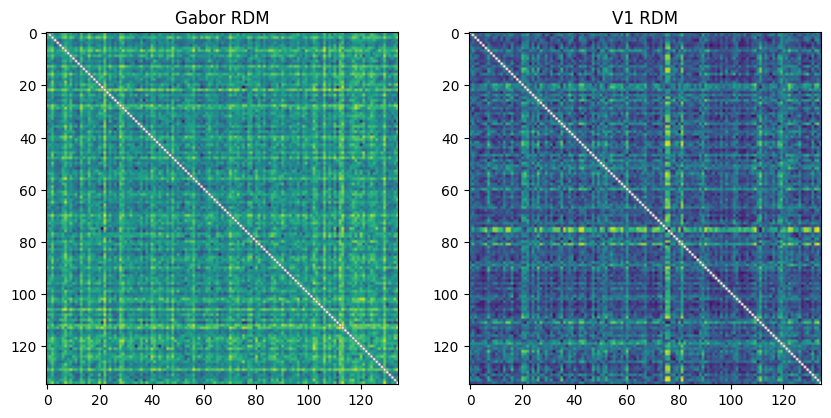

In [88]:
# transform the ordering of the stimuli for activations from V1
v1_features = v1_data_averaged.transpose('presentation', 'neuroid_id').values
v1_stimulus_ids = list(v1_data_averaged.stimulus_id.values)
v1_features = v1_features[[v1_stimulus_ids.index(sid) for sid in stimulus_ids]]

# compute RDMs
gabor_rdm = rdm(gabor_features)
v1_rdm = rdm(v1_features)

# set the diagonals to nan
n = gabor_features.shape[0]
gabor_rdm[range(n),range(n)] = np.nan
v1_rdm[range(n),range(n)] = np.nan

# compute them visually
fig, axes = pyplot.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(gabor_rdm)
axes[1].imshow(v1_rdm)
axes[0].set_title("Gabor RDM")
axes[1].set_title("V1 RDM")
pyplot.show()

Hmm, maybe they are not super similar.

To quantify the similarity, we can compare two RDMs by simply correlated all the coefficients (or entries) $A_{i,j}$ and $B_{i,j}$, except when $i<=j$: when $i< j$, it repeats the values in the case $j< i$ since the correlation matrix has diagonal symmetry; when $i=j$, the values are always $0$ (a stimulus is always similar to itself).


In [92]:
def rdm_metric(rdm1, rdm2):
    rdm1_upper_tri = rdm1[np.triu_indices(rdm1.shape[0], k=1)]
    rdm2_upper_tri = rdm2[np.triu_indices(rdm2.shape[0], k=1)]
    return np.corrcoef(rdm1_upper_tri, rdm2_upper_tri)[0, 1]

print(f"The RDM similarity between V1 and Gabor filtering is {rdm_metric(v1_rdm, gabor_rdm)}.")

The RDM similarity between V1 and Gabor filtering is 0.10318103068572053.


Hmm, we have some alignment but quite low. Why?

- There are also other cells in V1, like complex cells and cells that encode colors.
- Our choice of Gabor filter parameters can be different from the ones implemented in biological neurons.
- There are still internal noise in the V1 data. The course [NX-414](https://edu.epfl.ch/coursebook/en/brain-like-computation-and-intelligence-NX-414) talks more on this.

Additional references:
1. [VOneNet: CNNs with a Primary Visual Cortex Front-End](https://github.com/dicarlolab/vonenet)
2. [Tutorial on Gabor Filters, Javier R. Movellan](https://inc.ucsd.edu/mplab/75/media//gabor.pdf)